In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import scipy.stats as stats
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

In [2]:
# turn off debug to get cleaned source data
debug = False

In [3]:
%run merge-data.ipynb

<ipython-input-3-11ba52ca5917>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company']=df.apply(lambda x: getCompanyName(x.sponsor_collaborators, x.lead_sponsor, x.collaborators), axis=1)
<ipython-input-3-11ba52ca5917>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['symbol']=df.company.apply(lambda x: findSymbol(x, ticker_all))


In [5]:
# load saved price data
allprice=pd.read_csv('allprice.csv', index_col=0, parse_dates=True)
#allprice['Date'] = pd.to_datetime(allprice["Date"])

## Q2: Whether there is an impact when clinical trials are withdrawn/suspended

In [6]:
# temporary turn on debug when needed
#debug = True

# question related source data overview
if (debug):
    print('initial data shape: ', df.shape)
    print('total phases:', df['phases'].nunique(), df['phases'].unique())
    print('total status:', df['status'].nunique(), df['status'].unique())
    print('total symbols:', df['symbol'].nunique(), df['symbol'].unique())

In [65]:
# filter data to keep only relevent data points
q2=df[['symbol','company','phases', 'status','last_update_posted','completion_date', 'why_stopped']]
q2=q2.dropna(subset=['symbol','status','completion_date'])

if (debug):
    print('question related data shape: ', q2.shape)
    print('total status:', q2['status'].nunique(), q2['status'].unique())

In [66]:
#symbol performance during trail period using status date: last_update_posted
def getSymbolPerformance(symbol, date, offsetdays):    
#     startdate = datetime.strptime(date, "%Y-%m-%d") - timedelta(days=0) # same day
#     enddate = datetime.strptime(date, "%Y-%m-%d") + timedelta(days=5)  # 5 days after
    startdate = date - timedelta(days=offsetdays) 
    enddate = date + timedelta(days=offsetdays) 

    drange = pd.date_range(start=startdate, end=enddate)
    df = allprice[(allprice.symbol==symbol) & (allprice.index.isin(drange))]
    #df = allprice[(allprice.symbol==symbol) & (allprice.Date >= startdate) & (allprice.Date <= startdate)].sort_values('Date')
    
    if (df.empty):
        return None
    else:
        startprice = df.iloc[0].Open
        endprice = df.tail(1).Close.values[0]
        return 100*(endprice-startprice)/startprice


In [67]:
# testing
if debug:
    getSymbolPerformance('ABC','2020-02-10')

In [68]:
# all symbol performance
q2['performance2Weeks'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, x.completion_date, 14), axis=1)
q2['performance5Days'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, x.completion_date, 5), axis=1)
q2['performanceSameDay'] = q2.apply(lambda x: getSymbolPerformance(x.symbol, x.completion_date, 0), axis=1)
# default to 2 weeks
q2['performance'] = q2['performance2Weeks']

#q2 = q2.dropna(subset=['symbol','performance2Weeks','performance5Days','performanceSameDay']).sort_values('performance')
q2 = q2.dropna(subset=['symbol','performance']).sort_values('performance')

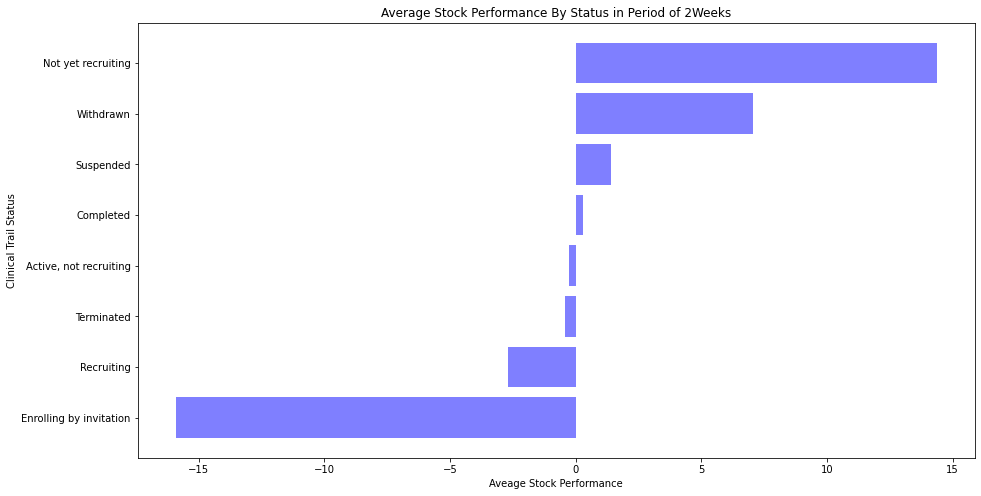

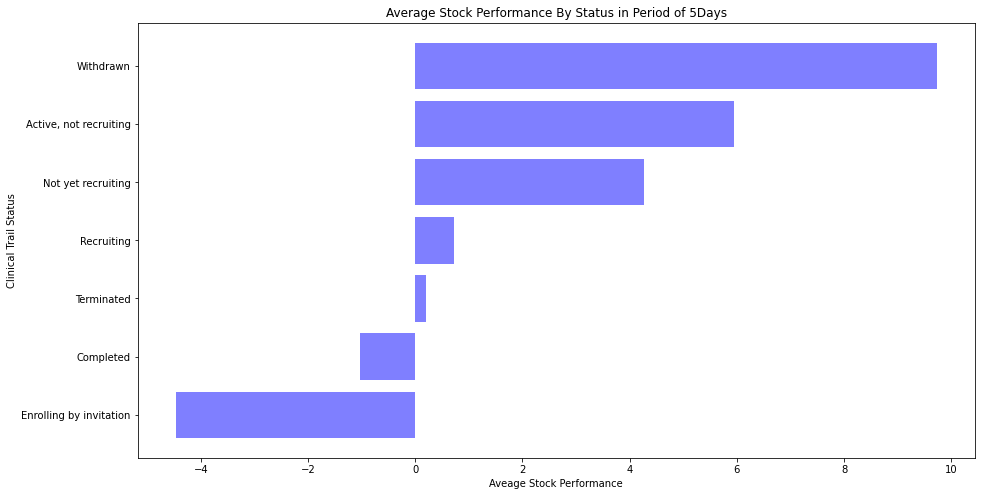

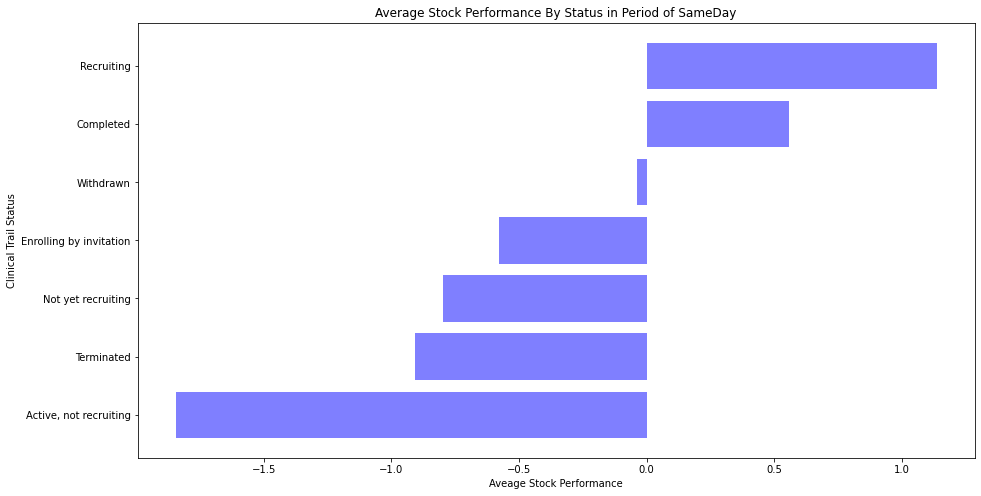

In [69]:
def averageBarChart(df, period):

    column = 'performance' + period
    #avgdf = df.groupby('status').mean('performance').sort_values('performance')
    avgdf = df.groupby('status').mean(column).sort_values(column)    

    plt.gcf().set_size_inches(15, 8)    
    plt.title("Average Stock Performance By Status in Period of " + period)
    #plt.barh(avgdf.index, avgdf["performance"], label="Average Performance", color="blue", alpha=0.5)
    plt.barh(avgdf.index, avgdf[column], label="Average Performance", color="blue", alpha=0.5)
    plt.xlabel("Aveage Stock Performance")
    plt.ylabel("Clinical Trail Status")
    #plt.legend(loc=0, frameon=True, title="")

    plt.show()
    return

averageBarChart(q2,'2Weeks')
averageBarChart(q2,'5Days')
averageBarChart(q2,'SameDay')

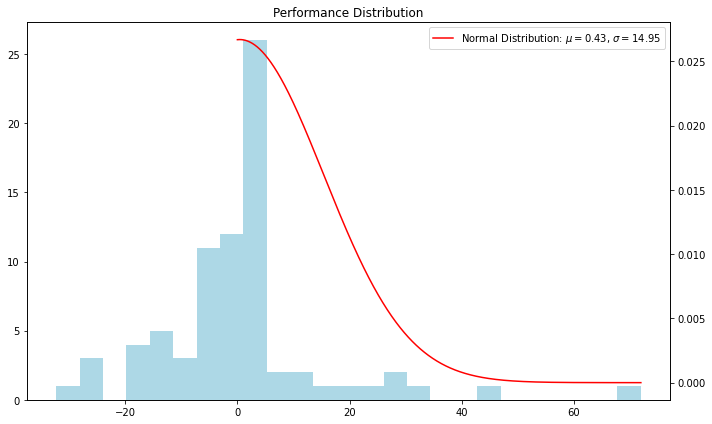

In [70]:
def histgramChart(df):
    dduration = df["performance"]
    mean, std, max = dduration.mean(), dduration.std(), dduration.max()

    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title("Performance Distribution")

    bins = 25
    ax.hist(dduration, bins, color="lightblue", label="Performance")

    # overlay a normal distribution
    ax1 = ax.twinx()
    x = np.linspace(0, max, 1000)
    y = stats.norm.pdf(x, mean, std)
    ax1.plot(x, y, color="r")
    ax1.legend(
        [
            "Normal Distribution: $\mu=$"
            + np.around(mean, 2).astype(str)
            + ", $\sigma=$"
            + np.around(std, 2).astype(str)
        ],
        loc=0,
    )

    fig.tight_layout()
    plt.show()
    return


histgramChart(q2)

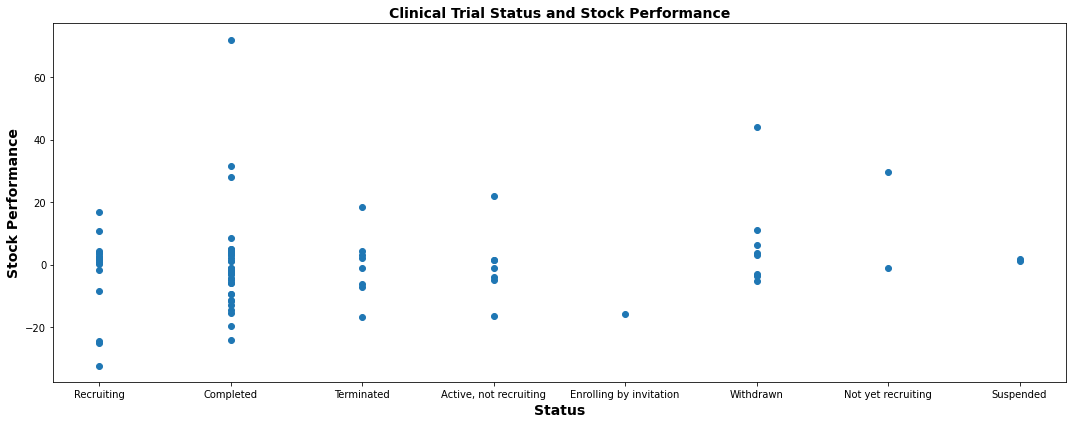

In [71]:
# visualization
def scatterChart(dx, dy):
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(15,6)

    title = 'Clinical Trial Status and Stock Performance'
    ax.scatter(dx, dy)    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel("Status", fontsize=14, fontweight='bold')
    ax.set_ylabel("Stock Performance", fontsize=14, fontweight='bold')    
    #ax.set_xticklabels(data.infection_case,rotation=75,horizontalalignment='right',fontweight='light',fontsize='large')

    fig.tight_layout()
    plt.show()
    return

scatterChart(q2["status"], q2.performance)

<AxesSubplot:xlabel='performance'>

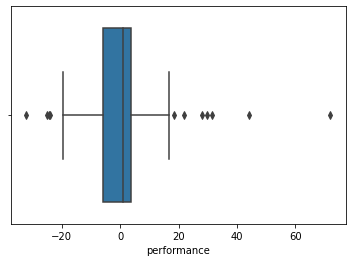

In [72]:
#visualize outliers
sns.boxplot(x=q2['performance'])

In [73]:
# remove outlier 1: z-score <-3 or >3
q2['zscore']=stats.zscore(q2['performance'])
q2['zscore']=stats.zscore(q2['performance'])
threshold1=3
threshold2=-3
q2_z = q2[(q2.zscore<threshold1) & (q2.zscore>threshold2)]
#print(q2_z.shape)

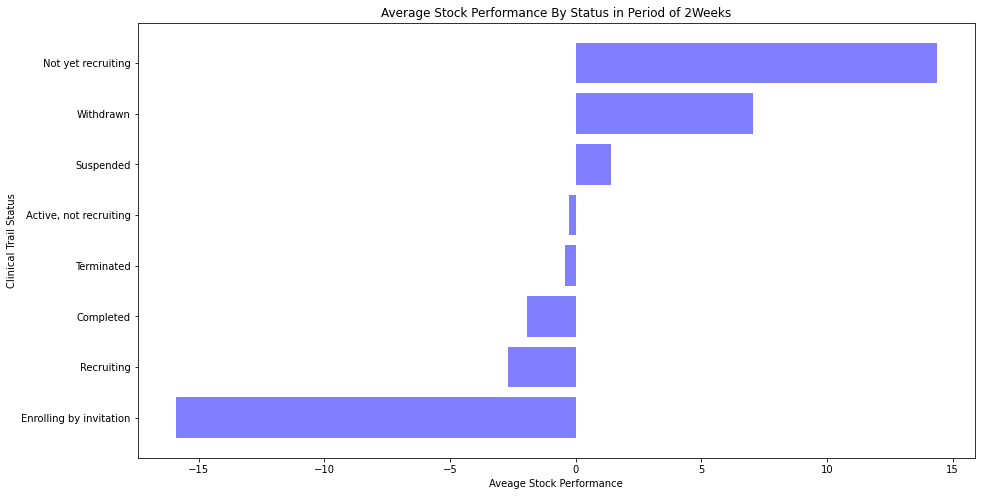

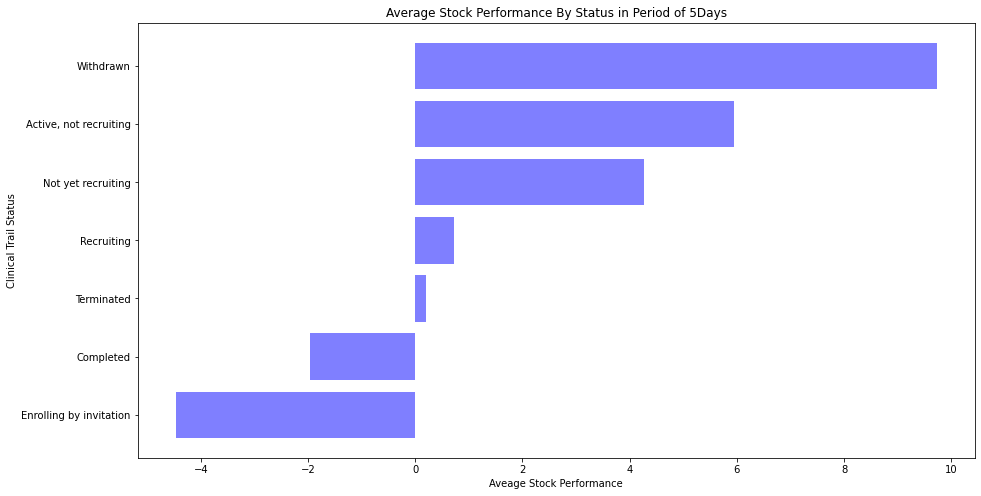

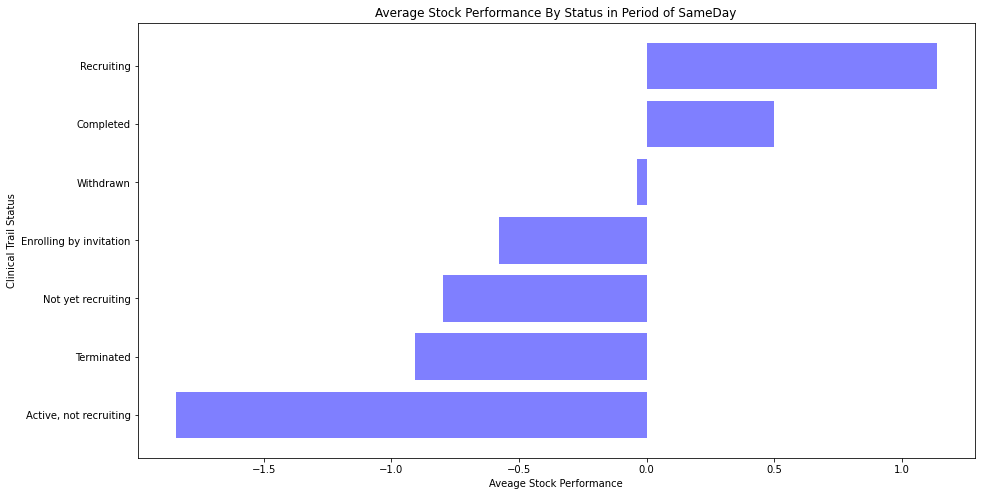

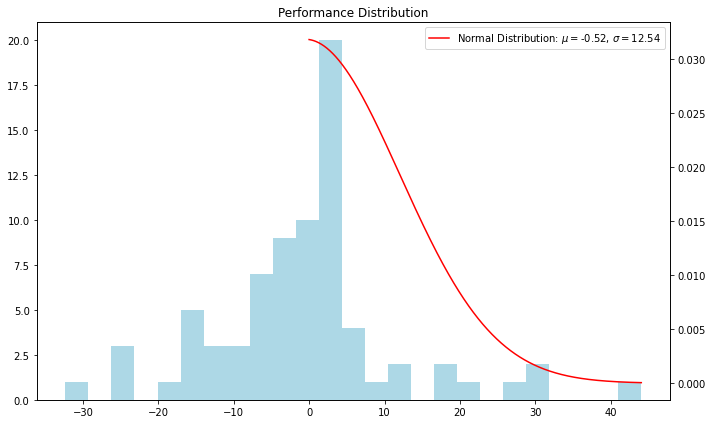

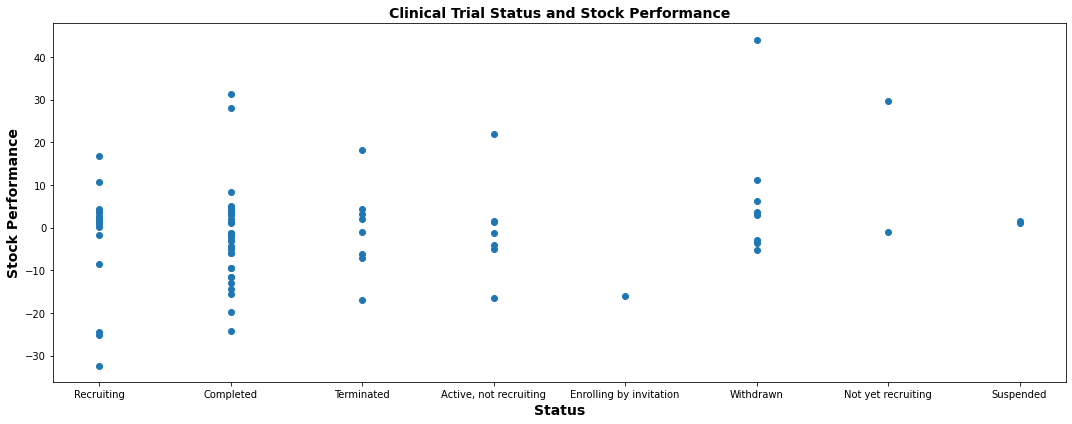

In [74]:
# chart again after removing outlier
averageBarChart(q2_z,'2Weeks')
averageBarChart(q2_z,'5Days')
averageBarChart(q2_z,'SameDay')
histgramChart(q2_z)
scatterChart(q2_z["status"], q2_z.performance)

In [75]:
# take a detailed look of withdrawn and suspended trails
q2[q2.status=='Withdrawn'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,completion_date,why_stopped,performance2Weeks,performance5Days,performanceSameDay,performance,zscore
767,KPTI,Karyopharm Inc,Phase 2,Withdrawn,2020-12-07,2020-08-30,No participants enrolled,-5.333335,6.359188,NaN,-5.333335,-0.387750
2461,XAIR,Beyond Air,Phase 2,Withdrawn,2021-01-22,2020-12-15,Terminated (halted prematurely),-3.717477,-2.214020,1.310856,-3.717477,-0.278944
1923,PFE,Pfizer,Phase 2,Withdrawn,2020-07-31,2020-10-18,Due to the pursuit of other SARS-CoV-2-related...,-2.874357,4.117808,NaN,-2.874357,-0.222171
2546,TAK,Takeda,Phase 1,Withdrawn,2020-10-08,2020-10-30,Business Decision (no enrollment),2.916677,-1.390577,-1.598465,2.916677,0.167777
1734,HOPE,Hope Pharmaceuticals,Phase 2,Withdrawn,2020-09-16,2020-08-15,No recruitment,3.727856,-5.328790,NaN,3.727856,0.222399
2696,BMY,Bristol-Myers Squibb,Phase 1|Phase 2,Withdrawn,2020-07-20,2020-12-31,Funding,6.355451,1.011002,0.960287,6.355451,0.399332
1505,EIGR,Eiger BioPharmaceuticals,Phase 2,Withdrawn,2021-02-26,2021-02-05,Due to the number of competing trials at their...,11.185469,25.766877,-0.819665,11.185469,0.724569
2447,SRNE,Sorrento,Phase 1,Withdrawn,2021-01-08,2021-01-31,Difficulty recruiting,44.044051,49.464666,NaN,44.044051,2.937152


In [76]:
q2[q2.status=='Suspended'].sort_values('performance')

,symbol,company,phases,status,last_update_posted,completion_date,why_stopped,performance2Weeks,performance5Days,performanceSameDay,performance,zscore
3259,IQV,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,2021-05-11,Study has been suspended due to the occurrence...,1.157208,NaN,NaN,1.157208,0.04930
3259,AZN,AstraZeneca|Iqvia |Covance,Phase 3,Suspended,2021-02-11,2021-05-11,Study has been suspended due to the occurrence...,1.609853,NaN,NaN,1.609853,0.07978


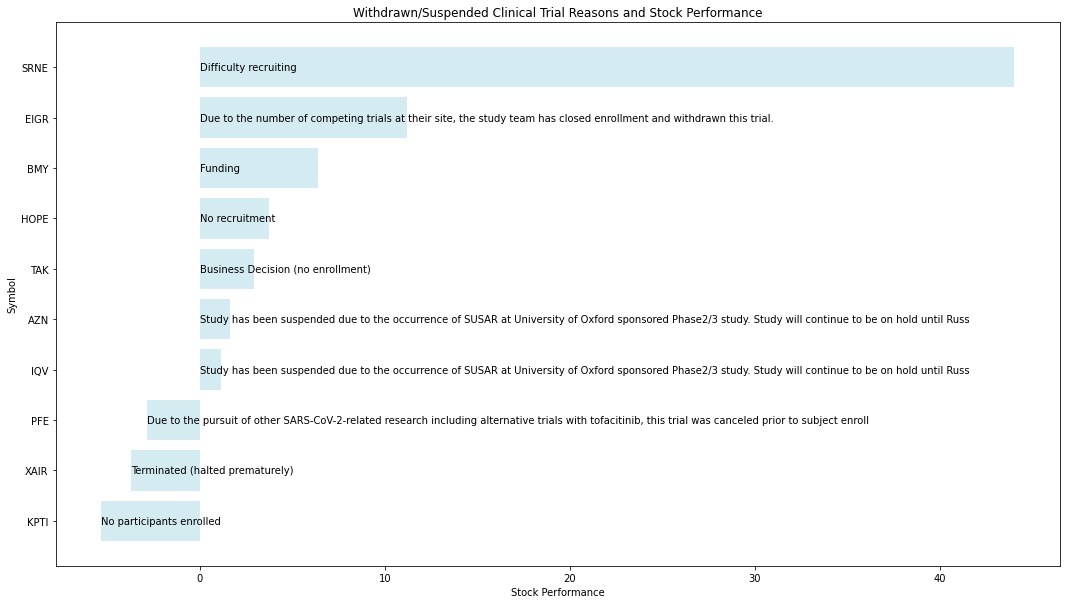

In [81]:
# explore withdrawn trails stopped reason
#q2why = q2[q2.status=='Withdrawn'].sort_values('performance')
#q2why = q2[q2.status=='Suspended'].sort_values('performance')
q2why = q2[(q2.status=='Withdrawn')|(q2.status=='Suspended')].sort_values('performance')
bar_label = q2why.why_stopped.tolist()

def autolabel(ax, rects):
    #for idx,rect in enumerate(bar_plot):
    for idx,rect in enumerate(rects):
        height = rect.get_height()
        width = rect.get_width()        
        if (width < 0):
            xstart = width
        else:
            xstart = 0        
        #print(idx, bar_label[idx])
        ax.text(xstart, rect.get_y() + height/2,
                bar_label[idx][:150],
                ha='left', va='center')

def stopReasonBarChart(df):    
    fig, ax = plt.subplots() 
    plt.gcf().set_size_inches(18,10)

    bar_plot = plt.barh(df.symbol, df.performance, label="perrformance", color="lightblue", alpha=0.5)
    #plt.yticks([], []) #remove y ticks
    autolabel(ax, bar_plot)

    plt.xlabel("Stock Performance")
    plt.ylabel("Symbol")   
    plt.title('Withdrawn/Suspended Clinical Trial Reasons and Stock Performance')
    plt.show()
    
stopReasonBarChart(q2why)